<a href="https://colab.research.google.com/github/gavieira/imersao-dados-2-2020/blob/master/Aula05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Aula 05

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# No vídeo, usou a url - facilita uso no Colab

#fonte = "https://raw.githubusercontent.com/gavieira/imersao-dados-2-2020/master/MICRODADOS_ENEM_2019_SAMPLE_43278.csv"
#dados = pd.read_csv(fonte)
#dados.head()


In [ ]:
#Setando variáveis

# Criadas na aula01
dados = pd.read_csv("MICRODADOS_ENEM_2019_SAMPLE_43278.csv")
provas = ["NU_NOTA_CN","NU_NOTA_CH","NU_NOTA_MT","NU_NOTA_LC","NU_NOTA_REDACAO"]

# Criadas na aula 02
renda_ordenada = np.sort(dados["Q006"].unique()) 
dados["NU_NOTA_TOTAL"] = dados[provas].sum(axis=1)
provas.append("NU_NOTA_TOTAL")
dados_sem_notas_zero = dados.query("NU_NOTA_TOTAL != 0")

# Aula 03
correlacao = dados_sem_notas_zero[provas].corr()

# Aula 04
provas_entrada = ["NU_NOTA_CH","NU_NOTA_LC", "NU_NOTA_CN","NU_NOTA_REDACAO"] # São nossas características, usadas para definir nossa saída
prova_saida = "NU_NOTA_MT" # È a nota que queremos prever
dados_sem_notas_zero = dados_sem_notas_zero[provas].dropna() #Remove os NaN (Not a number) para poder fazer o fit no modelo

notas_entrada = x = dados_sem_notas_zero[provas_entrada]
notas_saida = y = dados_sem_notas_zero[prova_saida]

SEED = 4321 # Poderia ser qqr numero
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.25,
                                                        random_state=SEED)


In [ ]:
from sklearn.svm import LinearSVR

modelo = LinearSVR(random_state=SEED)
modelo.fit(x_treino, y_treino)
predicoes_matematica = modelo.predict(x_teste)
mean_squared_error(y_teste, predicoes_matematica) #mse
#Se retirar o parametro random state, o mse muda cada vez que roda
#Precisamos retirar a aleatoriedade do modelo tanto quanto possível
#E tem modelos que dependem menos do random_state (ex: decision_tree, que só usa aleatoriedade em situações bem específicas)

/home/gabriel/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


18324.11972400897

In [ ]:
from sklearn.tree import DecisionTreeRegressor

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.25) # Para obter sempre o mesmo resultado de predição, basta comentar essa linha
modelo_arvore = DecisionTreeRegressor(max_depth = 3) #Não seta o random_state, e sim um parametro chamado max_depth
modelo_arvore.fit(x_treino, y_treino)
predicoes_matematica_arvore = modelo_arvore.predict(x_teste)
mean_squared_error(y_teste, predicoes_matematica_arvore)
#Decision_tree possui o parametro random_state na documentação, mas essa aleatoriedade só é usada em situações particulares
#Logo, não setamos o random_state, e mesmo assim o resultado é sempre o mesmo toda vez que roda, se dermos o mesmo dataset de treino
#Se dermos diferentes x_treino e y_treino, aí sim o resultado muda entre as runs
#A aleatoriedade desse e do ultimo modelo não está associado apenas ao random_state, mas tbm à divisão do dataset
#Logo, o decisiontree não é isento de aleatoriedade, mas tem um fator de aleatoriedade a mais (random_state)

5983.264315740933

**Cross-validation:** Pegar o seu dataset e separar em partes (folds ou quebras). O treino e teste são rodados várias vezes. Em cada run, se usa um fold de teste (e consequentemente de treino) diferente. Logo, os resultados variam e podemos evitar algum bias que estaria presente rodando o treino do modelo várias vezes e obtendo uma média desses treinos.

Lembra um pouco o bootstrap (reamostragem).

[Link wikipedia](https://en.wikipedia.org/wiki/Cross-validation_(statistics))

[![k-fold cross validation](imagens/k-fold_cross_validation.svg)](https://en.wikipedia.org/wiki/Cross-validation_(statistics))

In [20]:
# Fazendo o cross-validation
# A função cross_validate do sklearn usa por padrão o r2 como métrica de scoring. Podemos mudar a métrica com o parametro 'scoring' 

from sklearn.model_selection import cross_validate

modelo_arvore = DecisionTreeRegressor(max_depth=2) # Gera o modelo
resultados = cross_validate(modelo_arvore, x, y, cv= 10, scoring="neg_mean_squared_error") #Faz cross-validation com o modelo. Aqui usamos todos os dados (x e y) para os folds. Selecionamos 10 folds (parametro cv)
media = (resultados["test_score"]*-1).mean() # Só dá pra multiplicar assim pq é um array, não uma lista

# Usa mean_sq_error negativo pq assim quanto maior o valor, melhor. Foi uma escolha de implementação.
# E isso é meio que uma guideline de implementação de algoritmos mto comum, onde deve-se prezar por fazer com que quanto maiores os valores, melhores eles são. Isso é importante na otimização de algoritmos
# Para além disso, o que está sendo analisado é um score, uma nota (não uma função de erro). Algoritmos geralmente esperam que uma nota siga esse padrão de quanto maior, melhor
# Uma coisa é calcular erro, outra coisa é calcular um score (função de erro é diferente de função de score, sendo que a segunda mtas vezes é baseada na primeira)
# Podemos converter esses resultados negativos facilmente, multiplicando cada um deles por -1
#Por último, podemos obter a média desses resultados para comparar com os diversos modelos. Repare que essa média, baseada em várias iterações de treinamento, possivelmente representa melhor a performance do nosso modelo

#OBS: A idéia é que no cross-validation os scores sejam similares. Isso mostra que o modelo se comporta de forma uniforme ao ser treinado com diferentes entradas/grupos de dados.
# Se no cross-validation os scores forem muito diferentes, nosso modelo não é 'estável' o bastante e idealmente deve ser substituído por outro (em vez de decision tree, usar lasso, p. ex...)
#Logo, é importante obter esses scores e analisar eles: média, max, min, desvio padrão, etc...

# Amostragem é importante aqui. Não dá pra fazer cross-validation de forma satisfatória com 2, 3 observações...

In [ ]:
#Calculando desvio-padrão e o intervalo de confiança

from sklearn.model_selection import cross_validate

modelo_arvore = DecisionTreeRegressor(max_depth=2)
resultados = cross_validate(modelo_arvore, x, y, cv= 10, scoring="neg_mean_squared_error")
media = (resultados["test_score"]*-1).mean()
desvio_padrao = (resultados["test_score"]*-1).std()
#Calculando limites inferior e superior do intervalo de confiança
#Da estatística, tem-se que os limites desse intervalo são a média +- 2 * desvio padrão
#Ler depois sobre o lance dos 95% e intervalo de confiança

lim_inferior = media - (2*desvio_padrao) 
lim_superior = media + (2*desvio_padrao)

print(f"Intervalo de confiança {lim_inferior} - {lim_superior}")

Intervalo de confiança 6015.722549536811 - 7100.73277978073


In [ ]:
resultados["test_score"]*-1

array([6118.6911947 , 6536.09830186, 6338.64260896, 6456.70685686,
       6234.97203593, 6794.25120283, 6713.45694262, 6693.04880297,
       6610.58461646, 7085.82408339])

In [ ]:
def calcula_mse(resultados):
    media = (resultados["test_score"]*-1).mean()
    desvio_padrao = (resultados["test_score"]*-1).std()
    lim_inferior = media - (2*desvio_padrao)
    lim_superior = media + (2*desvio_padrao)
    print(f"Intervalo de confiança {lim_inferior} - {lim_superior}")

In [ ]:
# Cross-validate não tem função de aleatoriedade
# Pode replicar bias presentes em folds dos nossos dados e gerar resultados inesperados (ex: dados ordenados)
# Mas tem como adicionar um fator de seleção aleatória dos dados que estão nos folds
#Ou seja, dar uma embaralhada nos dados - o KFold do sklearn faz isso. Mas isso pode alterar o resultado cada vez que o modelo é rodado

#Para obter sempre o mesmo resultado, basta setar o random_state. Dá pra fazer isso com o numpy


from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
import numpy as np

SEED= 1232
np.random.seed(SEED) #Seta o random state para essa célula do notebook


partes = KFold(n_splits = 10, shuffle=True)
modelo_arvore = DecisionTreeRegressor(max_depth=3)
resultados = cross_validate(modelo_arvore, x, y, cv= partes, scoring="neg_mean_squared_error")
calcula_mse(resultados)

Intervalo de confiança 5858.741842392759 - 6250.793292491384


In [21]:
#Decision Tree: Vai separando os dados e se ramificando. Quanto mais ramos, maior a separação desses dados. Parâmetro max_depth limita isso.
#Max depth é um hiperparametro - um parametro cujo valor é usado para controlar o aprendizado da máquina.
#Os parametros que setamos ao construir o modelo vazio geralmente são hiperparametros
#Logo, esse hiperparametros alteram o resultado

#Será que quanto maior a profundidade da árvore, melhor o resultado?
#Vamos criar uma função que receba o max_depth como parametro e rode o modelo de árvore com esse valor de max_depth

def regressor_arvore(nivel):
    SEED= 1232
    np.random.seed(SEED)
    partes = KFold(n_splits = 10, shuffle=True)
    modelo_arvore = DecisionTreeRegressor(max_depth=nivel)
    resultados = cross_validate(modelo_arvore, x, y, cv= partes, scoring="neg_mean_squared_error", return_train_score=True) #return_train_score - retorna tanto o score do teste quanto do treino
    print(f"Treino = {(resultados['train_score']*-1).mean()}|Teste = {(resultados['test_score']*-1).mean()}")

regressor_arvore(4)

Treino = 5760.834451245899|Teste = 5815.707286597402


In [22]:
#Rodando o modelo de árvore para valores cada vez maiores de max_depth
#Os resultados do teste melhoram até certo ponto. Depois começam a piorar.
#Ou seja, no caso não é verdade que quanto maior o nível melhor o resultado do teste

#Agora, o resultado dos dados de treino em si sempre melhoram
#O modelo fica tão bom em prever os dados de treino, que ele não performa bem em dados de teste
#O modelo fica MTO familiar com os dados de treino, meio que 'decorando' eles. Não consegue extrapolar/generalizar para os dados de teste de forma adequada
#No nível 20, o modelo assimilou tanto os dados de treino, que ficou com um certo 'vício' baseado nesses dados.
#A esse problema de superajustamento do modelo aos dados de treino é dado o nome "overfit"
#Problema comum em ML, com diversas soluções
# O inverso desse problema ('underfit') também existe
#Link - https://towardsdatascience.com/overfitting-vs-underfitting-a-complete-example-d05dd7e19765
# https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/#:~:text=Overfitting%3A%20Good%20performance%20on%20the,poor%20generalization%20to%20other%20data

#Por mais que o depth=8 tenha dado um resultado melhor aqui, isso pode mudar se alterarmos outros parâmetros.
#Otimização de modelos de machine learning é um desafio, onde múltiplos (hiper)parametros e suas interações devem ser testados para chegar à melhor predição possível

for i in range(1,21):
    regressor_arvore(i)

Treino = 7844.952652412207|Teste = 7857.871770206351
Treino = 6527.783475408351|Teste = 6556.886287657656
Treino = 6021.275229419075|Teste = 6054.767567442072
Treino = 5760.834451245899|Teste = 5815.707286597402
Treino = 5598.158955426787|Teste = 5675.196789060744
Treino = 5469.677369145869|Teste = 5593.304363812442
Treino = 5369.458309852721|Teste = 5541.646599457925
Treino = 5276.16965707928|Teste = 5542.053091078966
Treino = 5166.713159932668|Teste = 5608.390265709719
Treino = 5022.598049115693|Teste = 5761.4934268457555
Treino = 4833.560706021637|Teste = 5955.331403579403
Treino = 4598.125022484774|Teste = 6217.553668629227
Treino = 4316.3791662866815|Teste = 6521.403312280134
Treino = 4000.6209880837496|Teste = 6853.984106997142
Treino = 3655.8197526274853|Teste = 7224.863053512405
Treino = 3295.832684540846|Teste = 7636.168819779455
Treino = 2931.7212612043877|Teste = 8071.851486256819
Treino = 2575.59534021339|Teste = 8452.126711298857
Treino = 2233.574203221172|Teste = 8833.470

Desafio 01: Pesquisar sobre intervalo de confiança (Quem quiser discutir no Discord, estaremos lá)

Muitos vídeos no [youtube](https://www.youtube.com/results?search_query=Confidence+interval). Assistir depois.

Desafio 02: Testar com outros parâmetros da árvore de decisão

In [29]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

#Testando hiperparametro "min_samples_split"

def regressor_arvore_split_min(split_min):
    SEED= 1232
    np.random.seed(SEED)
    partes = KFold(n_splits = 10, shuffle=True)
    modelo_arvore = DecisionTreeRegressor(min_samples_split=split_min)
    resultados = cross_validate(modelo_arvore, x, y, cv= partes, scoring="neg_mean_squared_error", return_train_score=True) #return_train_score - retorna tanto o score do teste quanto do treino
    print(f"Treino = {(resultados['train_score']*-1).mean()}|Teste = {(resultados['test_score']*-1).mean()}")

for i in [x / 10 for x in range(1,10)]:
    regressor_arvore_split_min(i)

#O resultado piora quando aumentamos o "min_samples_split" sem mexer em outros hiperparametros

Treino = 5984.048414609153|Teste = 6034.479134879735
Treino = 6242.3865302606555|Teste = 6278.959617783511
Treino = 6979.7598297237255|Teste = 6997.945411211392
Treino = 6979.7598297237255|Teste = 6997.945411211392
Treino = 7026.380963939734|Teste = 7041.700663450142
Treino = 7143.405886727303|Teste = 7156.7069630909655
Treino = 7143.405886727303|Teste = 7156.7069630909655
Treino = 7844.952652412207|Teste = 7857.871770206351
Treino = 7844.952652412207|Teste = 7857.871770206351


Desafio 03: Procurar outras formas de realizar os ajustes de parâmetros com o Sklearn

sklearn possui várias funções que basicamente automatizam esse processo de ver a qualidade do modelo com diversos parametros. Aqui usaremos o [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)

In [40]:
# https://scikit-learn.org/stable/modules/grid_search.html

#O escolhido foi o GridSearchCV - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV


from sklearn.model_selection import GridSearchCV


SEED= 1232
np.random.seed(SEED) #Seta o random state para essa célula do notebook

parameters = {'max_depth': [x for x in range(1,21)], 'min_samples_split':[x / 10 for x in range(1,10)]}
#print(parameters)

modelo_arvore = DecisionTreeRegressor()
grid = GridSearchCV(modelo_arvore, parameters, scoring="neg_mean_squared_error")
grid.fit(x_treino, y_treino)


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20],
  

In [41]:
#O que o grid nos retorna? Um dicionário
sorted(grid.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_max_depth',
 'param_min_samples_split',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [44]:
#array with score values
grid.cv_results_['mean_test_score']

array([-7860.88964172, -7860.88964172, -7860.88964172, -7860.88964172,
       -7860.88964172, -7860.88964172, -7860.88964172, -7860.88964172,
       -7860.88964172, -6531.00867822, -6531.00867822, -7124.5564794 ,
       -7124.5564794 , -7124.5564794 , -7124.5564794 , -7124.5564794 ,
       -7860.88964172, -7860.88964172, -6149.67964592, -6306.41933367,
       -7007.06049337, -7007.06049337, -7007.06049337, -7124.5564794 ,
       -7124.5564794 , -7860.88964172, -7860.88964172, -6041.82473208,
       -6266.24790436, -6966.88906407, -6966.88906407, -7007.06049337,
       -7124.5564794 , -7124.5564794 , -7860.88964172, -7860.88964172,
       -6007.02107991, -6239.55960222, -6966.88906407, -6966.88906407,
       -7007.06049337, -7124.5564794 , -7124.5564794 , -7860.88964172,
       -7860.88964172, -5995.20035294, -6239.55960222, -6966.88906407,
       -6966.88906407, -7007.06049337, -7124.5564794 , -7124.5564794 ,
       -7860.88964172, -7860.88964172, -5992.59637127, -6239.55960222,
      

In [43]:
# Aqui estamos falando do valor de score do teste. Ficou ligeiramente melhor que o que tínhamos
grid.best_score_

-5991.260955559202

In [58]:
#Quais são os valores dos melhores parametros?
grid.best_params_

#Observe que ao mudar o min_samples_split, o melhor valor de max_depth mudou

{'max_depth': 16, 'min_samples_split': 0.1}

In [60]:
#Usando o melhor estimador para predizer
grid.best_estimator_.predict(x_teste)

array([644.78144156, 581.26911011, 457.70666667, ..., 581.26911011,
       534.76694682, 445.01782488])

Desafio 04: Pesquisar o que é o problema de underfit.

Mesma coisa do desafio 01 - vários vídeos no [youtube](https://www.youtube.com/results?search_query=underfit+vs+overfit). Assistir depois

Desafio 05: Plotar um gráfico com test_score e train_test.

In [76]:
# Salvando valores de nível e mse de teste e treino em listas para plotar depois

def regressor_arvore(nivel):
    SEED= 1232
    np.random.seed(SEED)
    partes = KFold(n_splits = 10, shuffle=True)
    modelo_arvore = DecisionTreeRegressor(max_depth=nivel)
    resultados = cross_validate(modelo_arvore, x, y, cv= partes, scoring="neg_mean_squared_error", return_train_score=True) #return_train_score - retorna tanto o score do teste quanto do treino
    return (resultados['train_score']*-1).mean(), (resultados['test_score']*-1).mean()

nivel = []

train_score = []

teste_score = []

for i in range(1,21):
  train_sc, teste_sc = regressor_arvore(i)
  train_score.append(train_sc)
  teste_score.append(teste_sc)
  nivel.append(i)

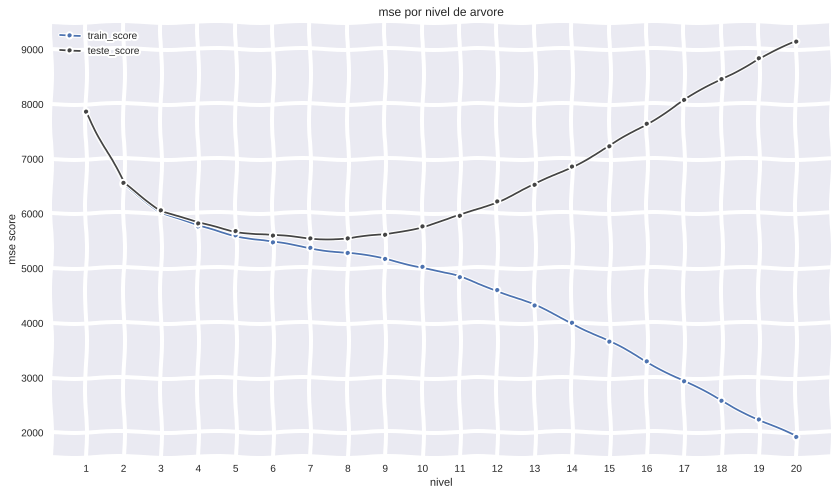

In [90]:
#Plotando o gráfico
# God bless cory schafer: https://www.youtube.com/watch?v=UO98lJQ3QGI&ab_channel=CoreySchafer


plt.figure(figsize=(14,8))

#print(plt.style.available)
plt.style.use("seaborn") # setando style

plt.grid(True)

plt.plot(nivel, train_score, marker=".", label='train_score')

plt.plot(nivel, teste_score, marker=".", color='#444444', label='teste_score')

plt.xticks(np.arange(min(nivel), max(nivel)+1, 1)) # Setando os ticks com o intervalo de 1

plt.xlabel('nivel')
plt.ylabel('mse score')
plt.title('mse por nivel de arvore')

plt.legend()